In [46]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pickle
sns.set_context('poster')
import glob
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, plot_roc_curve
from scipy.stats import pearsonr, spearmanr
from scipy.stats import wasserstein_distance
import os
import gn4pions.modules.resolution_util as ru
import gn4pions.modules.plot_util as pu
import atlas_mpl_style as ampl
ampl.set_color_cycle('Oceanic',10)
# plt.style.use('paper')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
ls -latrh results/no_cuts/

total 8.0K
drwxr-xr-x. 30 mpettee crd 4.0K Mar  3 13:25 ../
drwxr-xr-x.  3 mpettee crd  139 Mar  3 16:52 test_20220303/
drwxr-xr-x.  4 mpettee crd   48 Mar  4 08:07 ./
drwxr-xr-x.  2 mpettee crd 4.0K Mar  4 10:11 test_20220304/


In [48]:
data_dir = 'results/no_cuts/test_20220304/'

Loading from results/no_cuts/test_20220304/


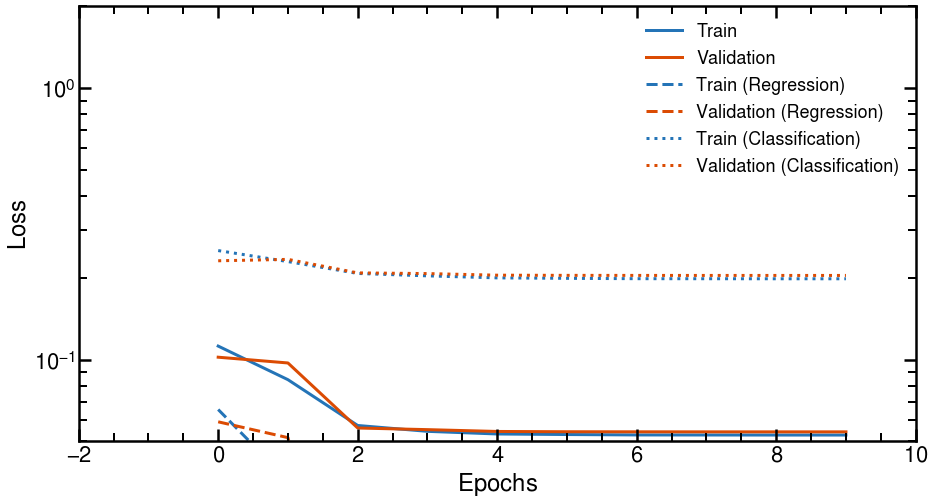

In [49]:
pion_list = ['pion']
sym_list = ['+-',]
concat_type = ['False']
model_name = ['ConcatFalse']
line = ['-', '--', ':']
blues = matplotlib.cm.Blues_r(np.linspace(0,1,20))
oranges = matplotlib.cm.Oranges_r(np.linspace(0,1,20))

plt.figure(figsize=(15,8))
hist_files = np.sort(glob.glob(data_dir + 'losses.npz'))
print('Loading from {}'.format(data_dir))


hist = np.load(hist_files[0])
plt.semilogy(hist['training'].mean(axis=1), color=blues[5, :3], 
             label=r'Train', linestyle=line[0])
plt.semilogy(hist['validation'].mean(axis=1), color=oranges[5, :3], 
             label=r'Validation', linestyle=line[0])

plt.semilogy(hist['training_regress'].mean(axis=1), color=blues[5, :3], 
             label=r'Train (Regression)', linestyle=line[1])
plt.semilogy(hist['validation_regress'].mean(axis=1), color=oranges[5, :3], 
             label=r'Validation (Regression)', linestyle=line[1])

plt.semilogy(hist['training_class'].mean(axis=1), color=blues[5, :3], 
             label=r'Train (Classification)', linestyle=line[2])
plt.semilogy(hist['validation_class'].mean(axis=1), color=oranges[5, :3], 
             label=r'Validation (Classification)', linestyle=line[2])


plt.ylabel(r'$Loss$')
plt.xlabel(r'$Epochs$')
plt.ylim([5e-2, 2])
# sns.despine()
plt.legend(loc="upper right", fontsize=18)
plt.savefig(data_dir+'/training_mse.png', bbox_inches='tight', dpi=300)
plt.show()

In [59]:
pred_file = data_dir+'/predictions.npz'
predictions = np.load(pred_file)
targets_regress = predictions['targets'][:, 0]
targets_class = predictions['targets'][:, 1]
outputs_regress = predictions['outputs'][:, 0]
outputs_class = predictions['outputs'][:, 1]
energies = predictions['energies']
etas = predictions['etas']

In [90]:
df = pd.DataFrame(np.vstack(
    [targets_class, outputs_class, targets_regress, outputs_regress, energies,etas]).T, 
                 columns = ["targets_class", "outputs_class", 
                  "targets_regress", "outputs_regress", "cluster_calib_E", "cluster_eta"])

df

,targets_class,outputs_class,targets_regress,outputs_regress,cluster_calib_E,cluster_eta
0,1.0,0.981732,125.917053,127.029747,66.654216,1.143146
1,1.0,0.994986,19.894951,19.826534,17.759507,0.728723
2,0.0,0.210802,6.760669,7.007188,1.624031,-1.110460
3,0.0,0.019466,14.120730,14.250596,13.108226,-0.035816
4,1.0,0.993172,551.386963,554.294495,15.703347,1.742677
...,...,...,...,...,...,...
279660,1.0,0.985510,612.953369,604.240356,6.607318,-1.626051
279661,0.0,0.572281,80.146736,79.021103,14.039299,2.426730
279662,0.0,0.016362,482.378296,479.646790,439.907705,-2.440128
279663,1.0,0.981529,1660.853882,1656.306763,19.963978,1.603946


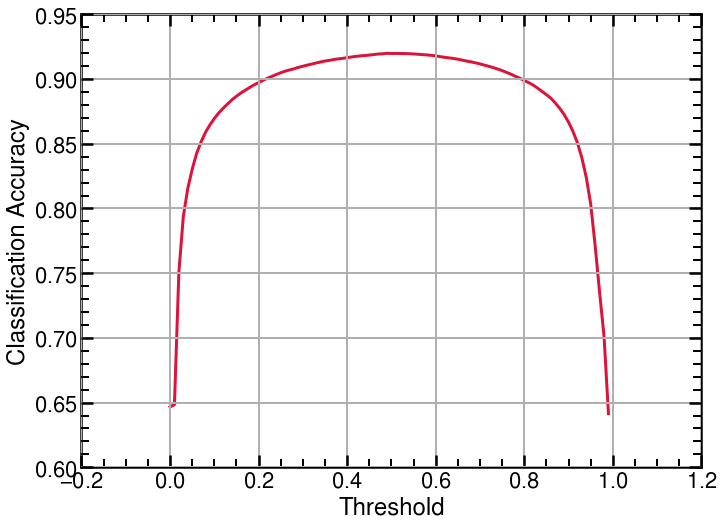

Max Acc: 91.986 at 0.49


In [54]:
acc = []
for i in np.arange(0, 1, .01):
    acc.append(accuracy_score(targets_class, outputs_class>i))
plt.plot(np.arange(0, 1, .01), acc, color="crimson")
plt.xlabel('Threshold')
plt.ylabel('Classification Accuracy')
plt.grid()
plt.savefig(data_dir+'/acc_threshold.png', bbox_inches='tight', dpi=300)
plt.show()
print('Max Acc: {:.3f} at {:.2f}'.format(100*np.max(acc), np.argmax(acc)*.01))

In [55]:
acc = accuracy_score(targets_class, outputs_class>.5)
prec = precision_score(targets_class, outputs_class>.5)
recall = recall_score(targets_class, outputs_class>.5)
f1 = f1_score(targets_class, outputs_class>.5)

print('Acc:\t{:.3f}\nPrec:\t{:.3f}\nRecall:\t{:.3f}\nF1:\t{:.3f}'.format(acc, prec, recall, f1))

Acc:	0.920
Prec:	0.939
Recall:	0.937
F1:	0.938


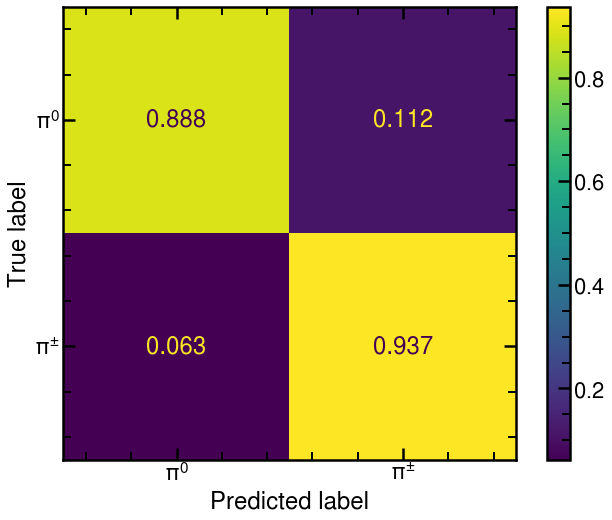

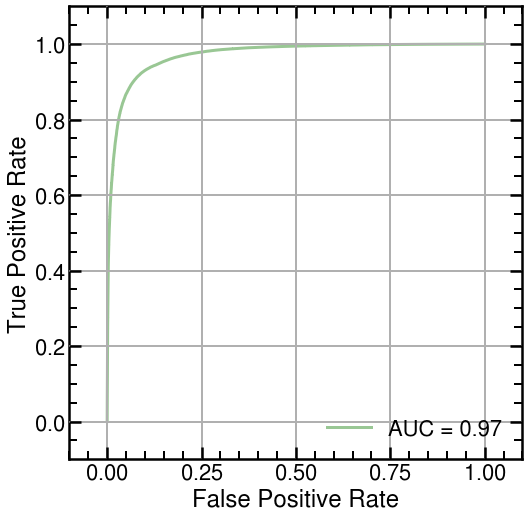

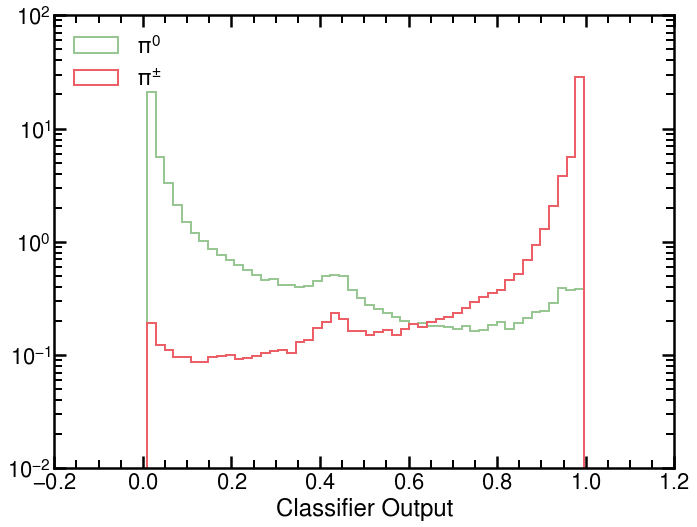

In [56]:
cm = confusion_matrix(targets_class, outputs_class>0.5, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['$\\pi^{0}$', '$\\pi^{\pm}$'])
disp.plot(values_format='.3f')
plt.savefig(data_dir+'/cm.png', dpi=300, bbox_inches='tight')
plt.show()

fpr, tpr, _ = roc_curve(targets_class, outputs_class)
roc_auc = auc(fpr, tpr)
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp.plot()
# plt.plot(fpr, tpr)
# plt.plot([-.2, 1.2], [-.2, 1.2], 'k')
plt.axis('square')
plt.xlim([-.1, 1.1])
plt.ylim([-.1, 1.1])
plt.grid()
plt.savefig(data_dir+'/roc_auc.png', dpi=300, bbox_inches='tight')
plt.show()

plt.hist(outputs_class[targets_class==0], 50, density=True, histtype='step', linewidth=2, label='$\\pi^{0}$')
plt.hist(outputs_class[targets_class==1], 50, density=True, histtype='step', linewidth=2, label='$\\pi^{\\pm}$')
plt.legend(loc='upper left')
plt.xlabel('Classifier Output')
plt.yscale('log')
plt.savefig(data_dir+'/class_dist.png', dpi=300, bbox_inches='tight')
plt.show()

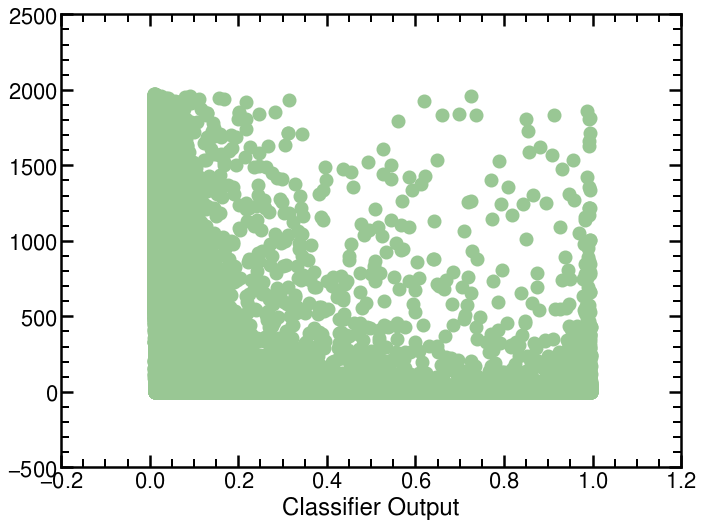

In [75]:
plt.scatter(outputs_class[targets_class==0], energies[targets_class==0])
# plt.legend(loc='upper left')
plt.xlabel('Classifier Output')
# plt.ylabel()
# plt.yscale('log')
# plt.savefig(data_dir+'/class_dist.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_16962/1262146334.py:12: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr, np.nan_to_num(1/fpr),label = "GNN (All energies)",)
/tmp/ipykernel_16962/1262146334.py:13: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_bin0, np.nan_to_num(1/fpr_bin0),label = "GNN (Cluster Energy < 1 GeV)",)
/tmp/ipykernel_16962/1262146334.py:14: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_bin1, np.nan_to_num(1/fpr_bin1),label = "GNN (1 < Cluster Energy / GeV < 10)",)
/tmp/ipykernel_16962/1262146334.py:15: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_bin2, np.nan_to_num(1/fpr_bin2),label = "GNN (10 < Cluster Energy / GeV < 50)",)
/tmp/ipykernel_16962/1262146334.py:16: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr_bin3, np.nan_to_num(1/fpr_bin3),label = "GNN (50 < Cluster Energy / GeV < 500)",)
/clusterfs/ml4hep/mpettee/miniconda3/envs/nbdev/lib/python3.9/site-pack

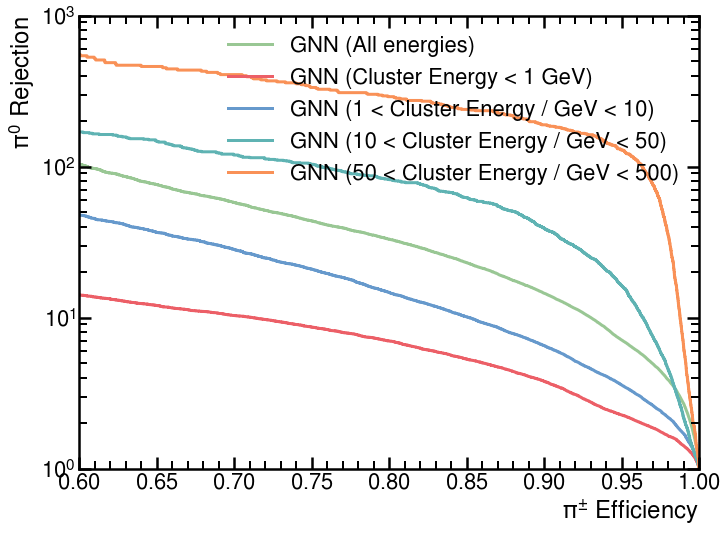

In [94]:
fpr, tpr, _ = roc_curve(df.targets_class, df.outputs_class)
fpr_bin0, tpr_bin0, _ = roc_curve(df[df.cluster_calib_E < 1].targets_class, 
                                  df[df.cluster_calib_E < 1].outputs_class)
fpr_bin1, tpr_bin1, _ = roc_curve(df[(df.cluster_calib_E > 1) & (df.cluster_calib_E < 10)].targets_class, 
                                  df[(df.cluster_calib_E > 1) & (df.cluster_calib_E < 10)].outputs_class)
fpr_bin2, tpr_bin2, _ = roc_curve(df[(df.cluster_calib_E > 10) & (df.cluster_calib_E < 50)].targets_class, 
                                  df[(df.cluster_calib_E > 10) & (df.cluster_calib_E < 50)].outputs_class)
fpr_bin3, tpr_bin3, _ = roc_curve(df[(df.cluster_calib_E > 50) & (df.cluster_calib_E < 500)].targets_class, 
                                  df[(df.cluster_calib_E > 50) & (df.cluster_calib_E < 500)].outputs_class)

plt.figure()
plt.plot(tpr, np.nan_to_num(1/fpr),label = "GNN (All energies)",)
plt.plot(tpr_bin0, np.nan_to_num(1/fpr_bin0),label = "GNN (Cluster Energy < 1 GeV)",)
plt.plot(tpr_bin1, np.nan_to_num(1/fpr_bin1),label = "GNN (1 < Cluster Energy / GeV < 10)",)
plt.plot(tpr_bin2, np.nan_to_num(1/fpr_bin2),label = "GNN (10 < Cluster Energy / GeV < 50)",)
plt.plot(tpr_bin3, np.nan_to_num(1/fpr_bin3),label = "GNN (50 < Cluster Energy / GeV < 500)",)
# plt.grid()
plt.xlim(0.6,1)
plt.yscale('log')
plt.ylim(0,1000)
ampl.set_xlabel(r"$\pi^{\pm}$ Efficiency");
ampl.set_ylabel(r"$\pi^0$ Rejection");
ampl.draw_atlas_label
plt.legend();

In [ ]:
def make_response_plot(y_true, y_pred, pion_label, f_name=''):
    y_ratio = y_pred/y_true

    p_r = pearsonr(y_true,y_pred)[0]
    s_r = spearmanr(y_true,y_pred)[0]
    mse = mean_squared_error(y_true,y_pred)
    mae = mean_absolute_error(y_true,y_pred)
    r2 = r2_score(y_true,y_pred)
    print("r2:{:.3f}".format(r2))
    print("PearsonR:{:.3f}, SpearmanR:{:.3f}, MSE:{:.3f}, MAE:{:.3f}".
          format(p_r, s_r, mse, mae))
    xcenter, medRegCNN = ru.responsePlot(y_true, y_ratio,
                                         figfile = f_name,
                                         statistic = 'median',
                                         atlas_x = 0.55, atlas_y = 0.95, simulation = True,
                                         textlist = [{'x': 0.55, 'y': 0.85, 'text': pion_label}])
    return xcenter, medRegCNN

In [ ]:
c_map = sns.color_palette("Blues")

pion_list = [
    '$\pi^{all}$', 
             '$\pi^{0}$', 
             '$\pi^{\pm}$']
sym_list = [
    '', 
            '0', 
            '+-'
           ]
blues = matplotlib.cm.Blues_r(np.linspace(0,1,20))
oranges = matplotlib.cm.Oranges_r(np.linspace(0,1,20))

response_median = []

print('\nPlotting {}'.format(pion_list[0]))
y_true = targets_regress
y_pred = outputs_regress
xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[0])
response_median.append(medRegCNN)

print('\nPlotting {}'.format(pion_list[1]))
y_true = targets_regress[targets_class==0]
y_pred = outputs_regress[targets_class==0]
xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[1])
response_median.append(medRegCNN)

print('\nPlotting {}'.format(pion_list[2]))
y_true = targets_regress[targets_class==1]
y_pred = outputs_regress[targets_class==1]
xcenter, medRegCNN = make_response_plot(y_true, y_pred, pion_list[2])
response_median.append(medRegCNN)

np.savez(data_dir+'/response_medians.npz', response_median=response_median, xcenter=xcenter)

In [ ]:
pu.lineOverlay(xcenter=xcenter, lines=response_median,  # [iqrOverMedpi0, iqrOverMedpiplus, iqrOverMedpiminus],
                labels = [
                    r'$\pi^{all}$', 
                    r'$\pi^{0}$', 
                    r'$\pi^{\pm}$'
                ],
                xlabel = 'Cluster Calib Hits [GeV]', ylabel = 'Response Median',
                figfile = '', # medResponse_gnBlock.png',
                y_max=1.2, y_min=.9, x_min = .3, colorgrouping=0,
                extra_lines= [[[0, 10e3], [1, 1]]],
                linestyles = ['solid', 'solid', 'solid'], # , 'dashed',],
                atlas_x = 0.05, atlas_y = 0.85, simulation = True,
                textlist = [{'x': 0.05, 'y': 0.775, 'text': 'Single $pions$'},
                            {'x': 0.05, 'y': 0.725,  'text': 'Regression Comparison'}])

In [ ]:
def make_hist_plot(y_true, y_pred, pion_label, f_name=None):
    print('Wasserstein distance: {:.3f}'.format(wasserstein_distance(y_true, y_pred)))
    fig = plt.figure(figsize=(20,10))
    plt.hist(y_true, bins=np.linspace(-1., 4., 100), alpha=.5, label=r'$True$')
    plt.hist(y_pred, bins=np.linspace(-1., 4., 100), alpha=.5, label=r'$Predicted$')
    plt.legend(loc='upper right')
    plt.xlabel(r'$Log\ values$')
    plt.ylabel(r'$Counts$')
    plt.xlim([-1.5, 4.])

    atlas_x = 0.55 
    atlas_y = 0.95 
    simulation = True
    textlist = [{'x': 0.55, 'y': 0.88, 'text': pion_label},
                {'x': 0.55, 'y': 0.83, 'text': 'Wasserstein distance: {:.4f}'.format(wasserstein_distance(y_true, y_pred))}]

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)
    # sns.despine()
    if f_name:
        plt.savefig(f_name)
    plt.show()

In [ ]:
import atlas_mpl_style as ampl
ampl.use_atlas_style()

# set plotsytle choices here
params = {'legend.fontsize': 24,
          'axes.labelsize': 32}
plt.rcParams.update(params)

ampl.set_color_cycle('Oceanic',10)

c_map = sns.color_palette("Blues")

pion_list = ['$\pi^{all}$', '$\pi^{0}$', '$\pi^{\pm}$']
blues = matplotlib.cm.Blues_r(np.linspace(0,1,20))
oranges = matplotlib.cm.Oranges_r(np.linspace(0,1,20))

print('\nPlotting {}'.format(pion_list[0]))
y_true = np.log10(targets_regress)
y_pred = np.log10(outputs_regress)
make_hist_plot(y_true, y_pred, pion_list[0])

print('\nPlotting {}'.format(pion_list[1]))
y_true = np.log10(targets_regress[targets_class==0])
y_pred = np.log10(outputs_regress[targets_class==0])
make_hist_plot(y_true, y_pred, pion_list[1])

print('\nPlotting {}'.format(pion_list[2]))
y_true = np.log10(targets_regress[targets_class==1])
y_pred = np.log10(outputs_regress[targets_class==1])
make_hist_plot(y_true, y_pred, pion_list[2])

In [ ]:
iqr = []
print('\nPlotting {}'.format(pion_list[0]))
y_true = targets_regress
y_pred = outputs_regress
y_ratio = y_pred/y_true
xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
iqr.append(iqr_curr)

print('\nPlotting {}'.format(pion_list[1]))
y_true = targets_regress[targets_class==0]
y_pred = outputs_regress[targets_class==0]
y_ratio = y_pred/y_true
xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
iqr.append(iqr_curr)

print('\nPlotting {}'.format(pion_list[2]))
y_true = targets_regress[targets_class==1]
y_pred = outputs_regress[targets_class==1]
y_ratio = y_pred/y_true
xcenter, iqr_curr= ru.resolutionPlot(y_true, y_ratio, statistic='iqrOverMed')
iqr.append(iqr_curr)

np.savez(data_dir+'/iqr.npz', response_median=iqr, xcenter=xcenter)

In [ ]:
pu.lineOverlay(xcenter=xcenter, lines = iqr,  # [iqrOverMedpi0, iqrOverMedpiplus, iqrOverMedpiminus],
                labels = [
                    r'$\pi^{all}$', 
                    r'$\pi^{0}$', 
                    r'$\pi^{\pm}$'],
                xlabel = 'Cluster Calib Hits [GeV]', ylabel = 'Response IQR / 2 x Median',
                figfile = '', # 'iqr_gnBlock.png',
                y_max = .6, x_min = .3,
                linestyles = ['solid', 'solid', 'solid'],  # , 'dashed',],
                atlas_x = 0.5, atlas_y = 0.375, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.275, 'text': 'Single $pions$'},
                            {'x': 0.5, 'y': 0.225,  'text': 'Regression Comparison'}])